In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import utils

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader = utils.loader(train=True, normalize=True)
test_loader = utils.loader(train=False, normalize=True)

In [4]:
class Net(nn.Module):
    def __init__(self, debug=False):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3)

        self.deconv1 = nn.ConvTranspose2d(16, 16, 3, stride=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, output_padding=1)
        
        self._loss = F.mse_loss
        self.debug=debug
        
    def forward(self, x):
        self.e1 = F.max_pool2d(F.relu(self.conv1(x)), 2)
        self.e2 = F.max_pool2d(F.relu(self.conv2(self.e1)), 2)
        self.lat = F.max_pool2d(F.relu(self.conv3(self.e2)), 2)
        
        self.d1 = F.relu(self.deconv1(self.lat))
        self.d2 = F.relu(self.deconv2(self.d1))
        self.out = F.tanh(self.deconv3(self.d2))
        
        if self.debug:
            print('x: ', x.shape)
            print('e1: ', self.e1.shape)
            print('e2: ', self.e2.shape)
            print('lat: ', self.lat.shape)
            print('d1: ', self.d1.shape)
            print('d2: ', self.d2.shape)
            print('out: ', self.out.shape)
            return
        return self.out

    def activations(self, x):
        l1 = self.conv1(x)
        l2 = self.conv2(F.max_pool2d(F.relu(l1), 2))
        l3 = self.conv3(F.max_pool2d(F.relu(l2), 2))
        return l1, l2, l3
        
    def decode(self):
        x = Variable(torch.eye(64).view(64, 16, 2, 2)[::4])
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        return F.tanh(self.deconv3(x))
    
    def loss(self, x, target, **kwargs):
        return self._loss(x, target, **kwargs)

In [5]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    else:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))

In [7]:
def test(log=None):
    test_loss = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += model.loss(output, data, size_average=False).data[0] # sum up batch loss
    test_loss /= len(test_loader.dataset) * 784
    
    train_loss = 0
    for data, target in train_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        train_loss += model.loss(output, data, size_average=False).data[0] # sum up batch loss
    train_loss /= len(train_loader.dataset) * 784
    
    print('Average test/train loss: {:.4f}/{:.4f}\n'.format(test_loss, train_loss))
    
    log['test'].append(test_loss)
    log['train'].append(train_loss)

In [8]:
err_log = {'test': [], 'train': []}
for epoch in range(1, 21):
    train(epoch)
    test(err_log)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.998295
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.508555
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.482521
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.455871
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.478378
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.494285
Train Epoch: 1 [59950/60000 (100%)]	Loss: 0.466633
Average test/train loss: 0.4602/0.4551

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.456345
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.428304
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.445327
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.414994
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.454918
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.454266
Train Epoch: 2 [59950/60000 (100%)]	Loss: 0.469491
Average test/train loss: 0.4512/0.4460

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.470598
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.408065
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.449456
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.435738
Train Epoch: 3 [40000/60000 (67%)

In [9]:
data, target = next(iter(train_loader))
data, target = Variable(data, volatile=True), Variable(target)

In [10]:
output = model(data)
to_plot = ((output+1)*0.5).clamp(0, 1).data.numpy()

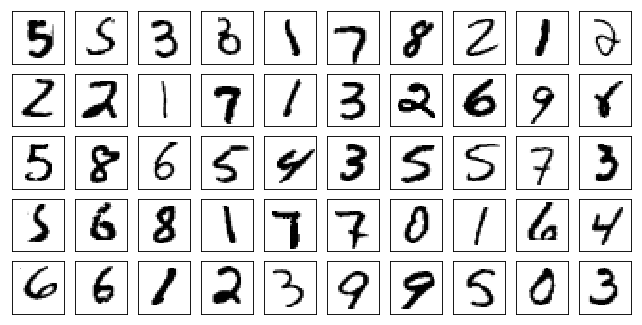

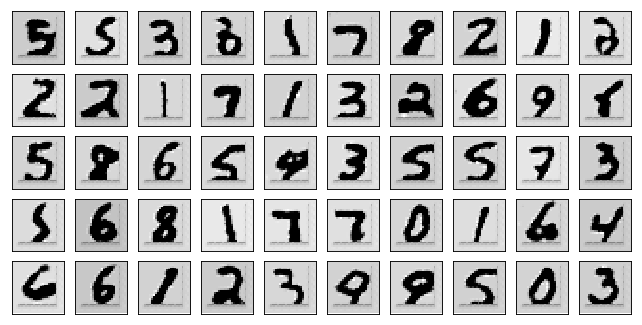

In [11]:
utils.plot_mnist(data.data.numpy(), (10, 5))
utils.plot_mnist(to_plot, (10, 5))

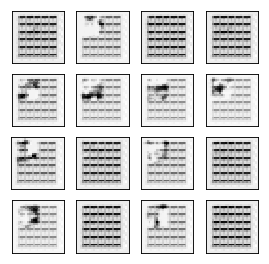

In [12]:
# x = Variable(torch.eye(64).view(64, 16, 2, 2)[::4])
# x = F.relu(model.deconv1(x))
# x = F.relu(model.deconv2(x))
# decoded = F.tanh(model.deconv3(x))
decoded = model.decode()
dec_to_plot = ((decoded+1)*0.5).clamp(0, 1).data.numpy()
utils.plot_mnist(dec_to_plot, (4, 4))

In [13]:
l1, l2, l3 = model.activations(data)
l1_to_plot = ((torch.tanh(l1)+1)*0.5).clamp(0, 1).data.numpy()
l2_to_plot = ((torch.tanh(l2)+1)*0.5).clamp(0, 1).data.numpy()
l3_to_plot = ((torch.tanh(l3)+1)*0.5).clamp(0, 1).data.numpy()

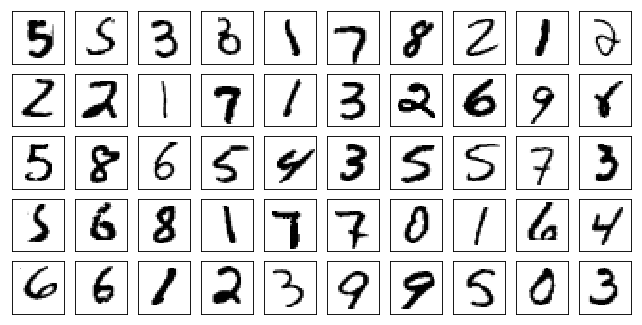

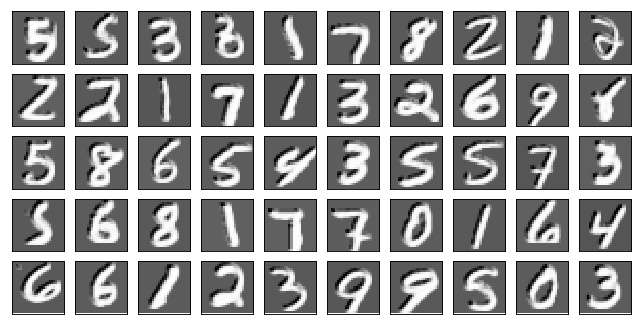

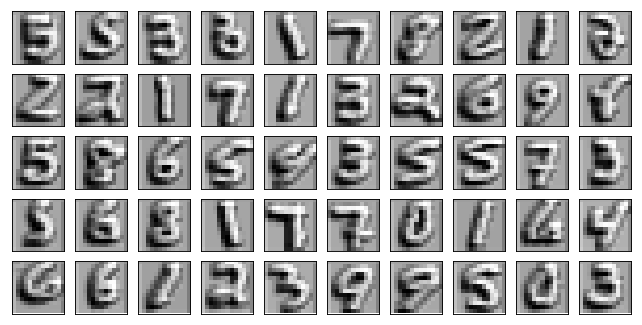

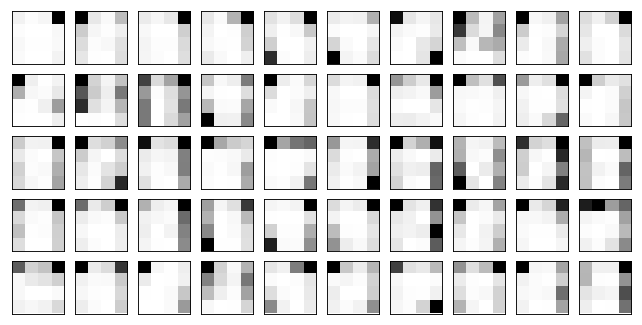

In [14]:
utils.plot_mnist(data.data.numpy(), (10, 5))
utils.plot_mnist(l1_to_plot, (10, 5))
utils.plot_mnist(l2_to_plot, (10, 5))
utils.plot_mnist(l3_to_plot, (10, 5))